In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
from brian2 import *
from brian2hears import *

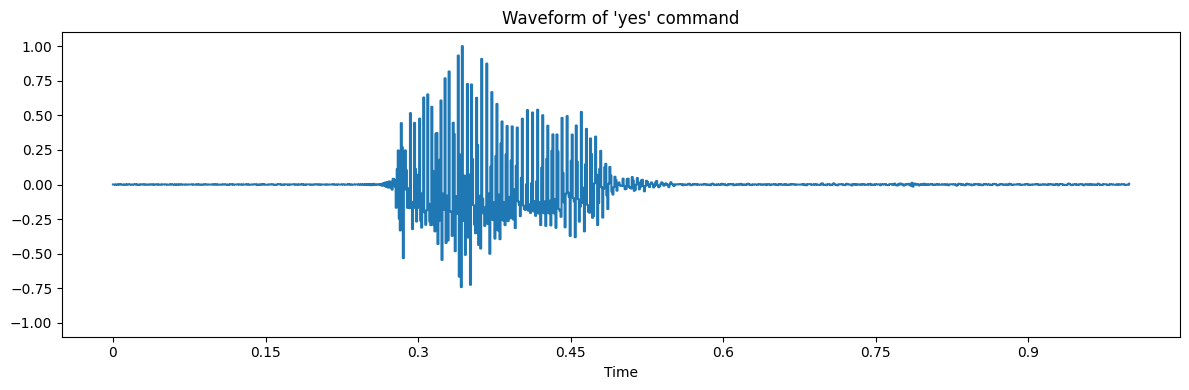

In [ ]:
y, sr = librosa.load("speech_command_dataset_v2/dataset/yes/0a7c2a8d_nohash_0.wav", sr=1000)

y = y / np.max(np.abs(y))  # Normalize the audio signal

plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform of 'yes' command")
plt.tight_layout()
plt.show()

WARNING    Removing unsupported flag '-march=native' from compiler flags. [brian2.codegen.cpp_prefs]
WARNING    Cannot use Cython, a test compilation failed: Cython is not available (ImportError)
Certain compiler configurations (e.g. clang in a conda environment on OS X) are known to be problematic. Note that you can switch the compiler by setting the 'CC' and 'CXX' environment variables. For example, you may want to try 'CC=gcc' and 'CXX=g++'. [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
WARNING    Cannot use Cython, a test compilation failed: Cython is not available (ImportError)
Certain compiler configurations (e.g. clang in a conda environment on OS X) are known to be problematic. Note that you can switch the compiler by setting the 'CC' and 'CXX' environment variables. For example, you may want to try 'CC=gcc' and 'CXX=g++'. [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]


Cochleagram shape: (1000, 8)
[[0.00199702 0.00338758 0.00555136 ... 0.01167545 0.01279325 0.01319543]
 [0.00457561 0.00317473 0.00520256 ... 0.01874257 0.01493613 0.01236633]
 [0.00428812 0.00297526 0.00487568 ... 0.01756494 0.01399766 0.01158933]
 ...
 [0.08773158 0.10478912 0.09332061 ... 0.12683732 0.14545548 0.14838983]
 [0.08221924 0.09820502 0.10203346 ... 0.11886789 0.14214396 0.14901489]
 [0.08374828 0.09203462 0.09562251 ... 0.14006132 0.16474711 0.17216233]]


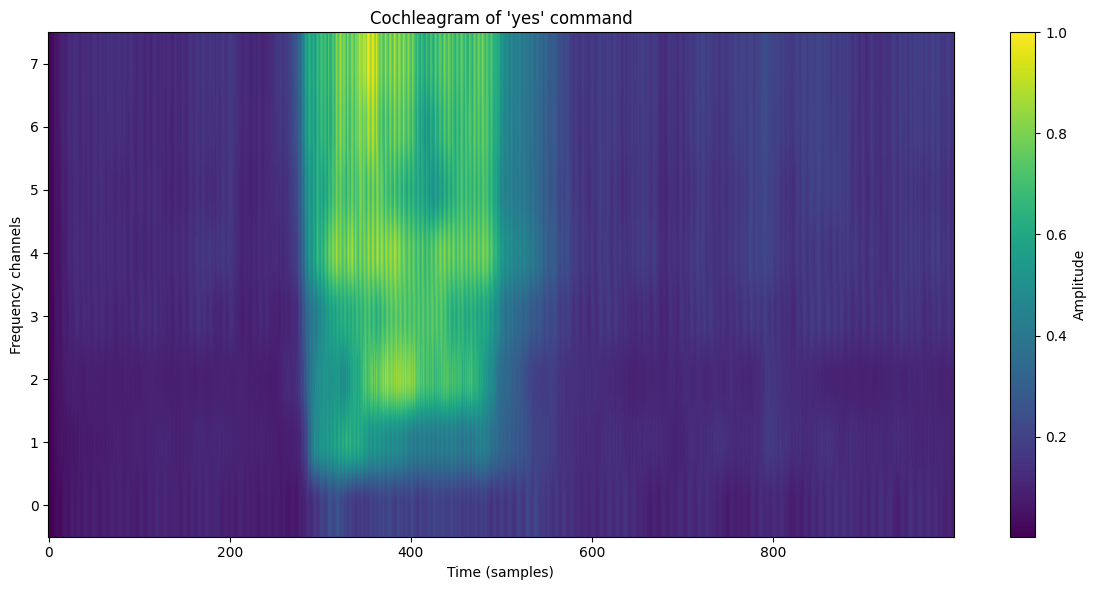

In [3]:
sound = Sound(y * Hz, sr * Hz)

cf = erbspace(100*Hz, 8000*Hz, 8)
gammatone = Gammatone(sound, cf)
envelope = FunctionFilterbank(gammatone, lambda x: np.maximum(x, 0)**(1.0/3.0))
lowpassed = LowPass(envelope, 10*Hz)
cochleagram = lowpassed.process()

cochleagram = np.array(cochleagram)

cochleagram = cochleagram / np.max(np.abs(cochleagram))

print("Cochleagram shape:", cochleagram.shape)
print(cochleagram)

plt.figure(figsize=(12, 6))
plt.imshow(cochleagram.T, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Amplitude')
plt.title("Cochleagram of 'yes' command")
plt.xlabel("Time (samples)")
plt.ylabel("Frequency channels")
plt.tight_layout()
plt.show()

In [4]:
cochleagram = cochleagram.T
channels_num, T = cochleagram.shape
print(f"Number of frequency channels: {channels_num}, Time steps: {T}")

Number of frequency channels: 8, Time steps: 1000


Spike matrix shape: (8, 1000)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


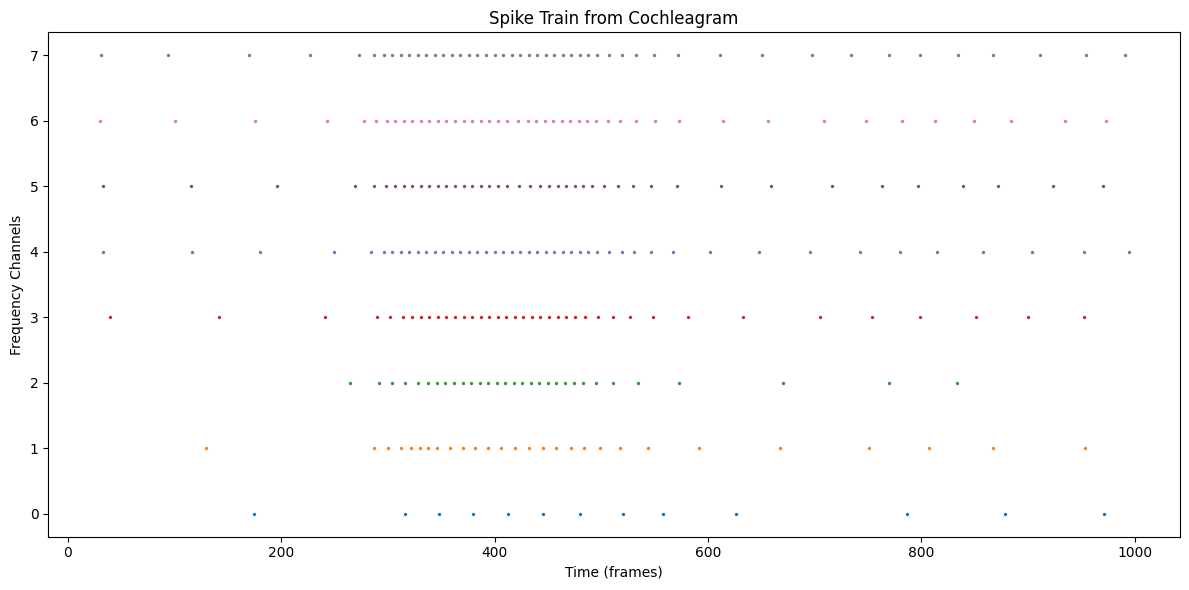

In [5]:
spike_matrix = np.zeros((channels_num, T))

dt = 1 * ms  # Time step
taum = 10 * ms
decay = np.exp(-dt / taum)  # Decay factor for the membrane potential
threshold = 1.1  # Spike threshold
refractory_time = 1  # Refractory period

for ch in range(channels_num):
    v = np.zeros(T + 1)
    refractory = False
    refractory_time_counter = 0 
    
    for t in range(T):
        v[t + 1] = decay * v[t] + cochleagram[ch, t]
        if v[t + 1] >= threshold:
            v[t + 1] = 0
            if refractory:
                if refractory_time_counter <= refractory_time:
                    refractory_time_counter += 1
                else:
                    refractory = False
            else:
                spike_matrix[ch, t] = 1
                refractory = True
                refractory_time_counter = 0
                

print("Spike matrix shape:", spike_matrix.shape)
print(spike_matrix)

fig, ax = plt.subplots(figsize=(12, 6))
for ch in range(spike_matrix.shape[0]):
    times = np.where(spike_matrix[ch])[0]
    ax.scatter(times, [ch]*len(times), s=2)
ax.set_title("Spike Train from Cochleagram")
ax.set_xlabel("Time (frames)")
ax.set_ylabel("Frequency Channels")
ax.set_yticks(np.arange(channels_num))
plt.tight_layout()
plt.show()
